# Installing Libraries

In [1]:
!pip install -q scikit-learn==1.4.1.post1 numpy==1.25.0 pandas==2.0.0 altair

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 42.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 26.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 23.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.0.3, but you have pandas 2.0.0 which is incompatible.


# Data Preparation
이번 실습에서는 스마트폰에서 수집된 가속도계 센서 데이터와 스마트폰 화면 상태를 나타내는 데이터를 활용해보자.

In [ ]:
import pandas as pd


URL_ACCEL = 'https://drive.usercontent.google.com/download?export=download&confirm=t&id=1UIVjudbwu8QvUpPhHGXuBVdetkbsUaO7'
URL_SCREEN = 'https://drive.usercontent.google.com/download?export=download&id=1UFNaH8f36sKTqYyUI0POS3ZWCJetKrkv'
URL_LABEL = 'https://drive.usercontent.google.com/download?export=download&id=1UPcYgOx5T8uZcvh1HL3g5BSlg9jOFuOf'

DF_ACCEL = pd.read_csv(URL_ACCEL)
DF_SCREEN = pd.read_csv(URL_SCREEN)
DF_LABEL = pd.read_csv(URL_LABEL)

In [ ]:
print(DF_ACCEL.shape)
DF_ACCEL.head()

(1604606, 6)


,sensor_type,device_type,timestamps,x,y,z
0,accelerometer,smartphone,1.454957e+12,-0.002,0.104,9.605
1,accelerometer,smartphone,1.454957e+12,0.001,0.123,9.622
2,accelerometer,smartphone,1.454957e+12,0.003,0.129,9.647
3,accelerometer,smartphone,1.454957e+12,-0.002,0.119,9.603
4,accelerometer,smartphone,1.454957e+12,-0.002,0.119,9.603


In [ ]:
print(DF_SCREEN.shape)
DF_SCREEN.head()

(99, 4)


,sensor_type,device_type,timestamps,status
0,screen,smartphone,1.454958e+12,SCREEN_ON
1,screen,smartphone,1.454958e+12,SCREEN_OFF
2,screen,smartphone,1.454961e+12,SCREEN_ON
3,screen,smartphone,1.454961e+12,SCREEN_OFF
4,screen,smartphone,1.454961e+12,SCREEN_ON


In [ ]:
print(DF_LABEL.shape)
DF_LABEL.head()

(25, 7)


,sensor_type,device_type,label,label_start,label_start_datetime,label_end,label_end_datetime
0,interval_label,smartphone,On Table,1.454956e+12,08/02/2016 10:33:13,1.454957e+12,08/02/2016 10:36:18
1,interval_label,smartphone,Driving,1.454961e+12,08/02/2016 11:44:02,1.454961e+12,08/02/2016 11:53:27
2,interval_label,smartphone,Washing Hands,1.454958e+12,08/02/2016 10:57:49,1.454958e+12,08/02/2016 10:58:36
3,interval_label,smartphone,Washing Hands,1.454960e+12,08/02/2016 11:26:33,1.454960e+12,08/02/2016 11:27:31
4,interval_label,smartphone,Standing,1.454962e+12,08/02/2016 12:03:17,1.454962e+12,08/02/2016 12:06:14


보다시피, 스마트폰에서 3축 가속도계 센서 데이터, 스마트폰 화면 상태를 나타내는 데이터, 사용자의 행동을 나타내는 레이블 데이터가 각각 따로 존재한다.

# Preprocessing Label
지금까지는 특성값들 + 레이블 형태의 테이블로 된 데이터만 실습했지만, 사실 멀티 모달 데이터의 경우는 각 모달리티 별로 수집된 데이터 파일과 레이블 파일이 서로 분리되어 있는 경우가 훨씬 많다. 이번 실습(그리고 팀 프로젝트)에서 해볼 행동 인식 분야의 경우, 특정한 행동이 시작-종료된 지점을 기록하는 식으로 레이블 데이터를 생성한다.

그럼 우리가 알던 통합된 테이블 형태로는 어떻게 만들 수 있을까? 그건 기계 학습 모델이 적용될 응용시나리오마다 다르다. 가령, 1초(의 데이터)마다 특정한 레이블을 출력하는 기계학습 모델을 만들고 싶다면, 원래 있는 레이블 데이터를 1초 단위로 쪼개어 레이블을 부여하는 것이다. 이를 위해선 약간의 트릭이 필요하다.

먼저, 레이블 시작 지점과 그에 해당하는 레이블로 된 테이블만 따로 뽑아내고, 레이블 시작 지점을 의미하는 필드의 이름을 바꾼다.


In [ ]:
label_start = DF_LABEL[['label_start', 'label']].rename(
    {'label_start': 'timestamps'}, axis=1
)

이번엔, 레이블 종료 시점에 해당하는 레이블로 된 데이터를 뽑아내고, 그 데이터에 임의의 레이블(예. UNDEFINED)를 부여한 후, 레이블 종료 시점을 의미하는 필드의 이름을 바꾼다.

In [ ]:
label_end = DF_LABEL[['label_end']].assign(
    label='UNDEFINED'
).rename(
    {'label_end': 'timestamps'}, axis=1
)

두 개의 테이블을 하나로 합친 후, 시간 순으로 정렬한다.

In [ ]:
import pandas as pd


label = pd.concat([label_start, label_end], ignore_index=True, axis=0).sort_values('timestamps')
label.head()

,timestamps,label
12,1.454956e+12,On Table
37,1.454956e+12,UNDEFINED
0,1.454956e+12,On Table
25,1.454957e+12,UNDEFINED
11,1.454957e+12,On Table


위 데이터가 의미하는 바는 특정한 레이블이 시작하는 시점을 표시하는 것이다. 만약, UNDEFINED가 기록되어 있다면, 이전 레이블이 종료되었고, 아무런 레이블이 없는 임의의 레이블이 시작되었다는 것을 의미한다.

이젠, 위의 데이터를 1초 단위로 끊어보겠다. 이 방법을 적용하기 위해선, 위 데이터를 시간을 인덱스로 삼는 데이터로 변환해야 한다.

In [ ]:
label_t_index = label.assign(
    timestamps=lambda x: pd.to_datetime(x['timestamps'], unit='ms')
).set_index('timestamps')['label']
label_t_index.head()

timestamps
2016-02-08 18:28:52.985999616     On Table
2016-02-08 18:32:46.574000128    UNDEFINED
2016-02-08 18:33:13.088000000     On Table
2016-02-08 18:36:18.385999616    UNDEFINED
2016-02-08 18:36:48.514999808     On Table
Name: label, dtype: object

그 다음에는 이 데이터를 1초 단위로 Upsampling 한다. 이러면 데이터는 다음과 같은 식으로 변한다.

|timestamps|label|
|---|---|
|1|On Table|
|2|NaN|
|3|NaN|
|4|NaN|
|5|UNDEFINED|
|6|NaN|
|7|NaN|
|......|

NaN 부분이 Upsamping으로 인하여 새로 생긴 지점이며, 이미 채워져있는 부분은 원본 데이터에 있는 부분, 즉 레이블 시작 지점이다. 당연히, 다른 레이블이 시작하기 전에 존재하는 NaN은 이전에 시작한 레이블로 채워져야한다(Forward Filling).

복잡해 보이지만, 한줄이면 된다.

In [ ]:
import pandas as pd


LABEL = label_t_index.resample(
    '1s' # 1초 단위로 Upsamping
 ).ffill().dropna() # Foward filling

LABEL

timestamps
2016-02-08 18:28:53    On Table
2016-02-08 18:28:54    On Table
2016-02-08 18:28:55    On Table
2016-02-08 18:28:56    On Table
2016-02-08 18:28:57    On Table
                         ...   
2016-02-08 20:25:39     Walking
2016-02-08 20:25:40     Walking
2016-02-08 20:25:41     Walking
2016-02-08 20:25:42     Walking
2016-02-08 20:25:43     Walking
Freq: S, Name: label, Length: 7011, dtype: object

위처럼 1초 단위로 레이블이 매겨진 것을 알 수 있다.

# Feature Extraction on Numercial Data
이번엔 Sliding Window를 적용해서 여러가지 특성값을 뽑아보겠다. 일단 그 전에 역시 몇 가지 사전 작업이 필요하다.

## Preprocessing

시간 영역이든, 주파수 영역이든 윈도우 내의 데이터 개수는 통일되어야 한다. 먼저, 가속도계 데이터의 전체 샘플링 주파수를 확인해보자.


In [ ]:
len(DF_ACCEL) / (DF_ACCEL['timestamps'].max() - DF_ACCEL['timestamps'].min()) * 1000

201.60037073050265

201.6 Hz로 수집된 것을 알 수 있다. 보통 센서 스펙에서는 10의 자리로 끊지만, 실제로 수집되는 샘플링 주파수는 스펙과 조금씩 다를 수 있다. 이 데이터를 200Hz로 만들어주자.

In [ ]:
import pandas as pd


accel = DF_ACCEL.assign(
    timestamps=lambda x: pd.to_datetime(x['timestamps'], unit='ms')
).set_index('timestamps')[['x', 'y', 'z']].sort_index()
accel.head()

,x,y,z
timestamps,,,
2016-02-08 18:28:25.656222464,-0.087,0.181,9.621
2016-02-08 18:28:25.660105728,-0.069,0.153,9.663
2016-02-08 18:28:25.667091456,-0.073,0.156,9.647
2016-02-08 18:28:25.670696704,-0.070,0.184,9.623
2016-02-08 18:28:25.675807488,-0.059,0.171,9.625


그 다음에는, 200 Hz로 Downsampling 한다.

In [ ]:
ACCEL = accel.resample('5ms').nearest()
ACCEL

,x,y,z
timestamps,,,
2016-02-08 18:28:25.655,-0.087,0.181,9.621
2016-02-08 18:28:25.660,-0.069,0.153,9.663
2016-02-08 18:28:25.665,-0.073,0.156,9.647
2016-02-08 18:28:25.670,-0.070,0.184,9.623
2016-02-08 18:28:25.675,-0.059,0.171,9.625
...,...,...,...
2016-02-08 20:41:04.975,-0.166,0.178,9.628
2016-02-08 20:41:04.980,-0.166,0.178,9.628
2016-02-08 20:41:04.985,-0.174,0.183,9.643


윈도우 내에 있는 데이터로부터 레이블을 예측할 수 있는 특성값을 추출하는 것이 목적이므로, 레이블에 있는 시간을 따라가면서 특성값을 추출하면 된다. 이 실습에서는 윈도우 크기 $\lambda$를 3초 (= 600개 데이터), 스트라이드 $\delta$를 1초로 하겠다. 즉, 연속된 두 윈도우가 겹치는 구간은 2초가 된다.

먼저, 윈도우마다 정확히 데이터의 수가 600개인지 확인해보자.

In [ ]:
import pandas as pd


for t in LABEL.index:
    sub = ACCEL.loc[t - pd.Timedelta(seconds=3):t - pd.Timedelta(milliseconds=1)]
    assert len(sub) == 600

다행히도 모든 윈도우 내의 데이터가 600개임을 알 수 있다. 물론, 아니라고 해도 크게 걱정하지 않아도 된다. 한 두개 차이 정도는 크게 의미가 없으며, 위에서 한 것처럼 윈도우 내의 데이터에 대해 샘플수를 조정하면 되기 때문이다.




## Time-Domain Features
어찌되었든, 수업시간에 다룬 수많은 특성값 중에 간단하게 평균과 분산만 구한 후에, 특성값과 레이블을 하나의 테이블로 만들어보자.



In [ ]:
import pandas as pd
import numpy as np


DATA_NT = []

for t in LABEL.index:
    l = LABEL[t]
    sub = ACCEL.loc[t - pd.Timedelta(seconds=3):t - pd.Timedelta(milliseconds=1)]
    mean_x = np.mean(sub['x'])
    mean_y = np.mean(sub['y'])
    mean_z = np.mean(sub['z'])
    var_x = np.var(sub['x'], ddof=1)
    var_y = np.var(sub['y'], ddof=1)
    var_z = np.var(sub['z'], ddof=1)

    DATA_NT.append(
        (t, l, mean_x, mean_y, mean_z, var_x, var_y, var_z)
    )

DATA_NT = pd.DataFrame(DATA_NT, columns=['timestamps', 'label', 'mean_x', 'mean_y', 'mean_z', 'var_x', 'var_y', 'var_z']).set_index(
    'timestamps'
)
DATA_NT

,label,mean_x,mean_y,mean_z,var_x,var_y,var_z
timestamps,,,,,,,
2016-02-08 18:28:53,On Table,-0.070873,0.111298,9.617108,0.000202,0.000136,0.000330
2016-02-08 18:28:54,On Table,-0.071902,0.110887,9.618853,0.000166,0.000141,0.000300
2016-02-08 18:28:55,On Table,-0.071267,0.110860,9.619180,0.000243,0.000150,0.000339
2016-02-08 18:28:56,On Table,-0.071517,0.111988,9.618132,0.000254,0.000169,0.000318
2016-02-08 18:28:57,On Table,-0.071482,0.112753,9.617612,0.000279,0.000195,0.000337
...,...,...,...,...,...,...,...
2016-02-08 20:25:39,Walking,0.248290,9.745872,-0.199765,3.731656,6.163083,7.555178
2016-02-08 20:25:40,Walking,0.144238,9.699710,-0.531423,3.309211,3.374742,6.950652
2016-02-08 20:25:41,Walking,-1.119167,9.436993,0.017180,6.601185,3.908427,7.787462


이제야 우리가 알던 데이터 형태가 나왔다. 한번 시각화해보자.

In [ ]:
import altair as alt
import numpy as np


alt.data_transformers.disable_max_rows()
plots = alt.vconcat()

for feature in ['mean_x', 'mean_y', 'mean_z', 'var_x', 'var_y', 'var_z']:
    p = alt.Chart(DATA_NT).encode(
        x='label', y=f'{feature}:Q'
    ).mark_boxplot().properties(width=400)
    plots = plots & p

plots

alt.VConcatChart(...)

## FFT Toy Example
주파수 영역의 특성값을 추출하기 전에, 가상의 데이터를 활용해서 실습해보자.


In [ ]:
import numpy as np
import altair as alt
import pandas as pd


f_s = 100

x = np.arange(0, 5, 1 / f_s)
s1 = np.cos(2 * np.pi * x * 0.5)
s2 = 2 * np.cos(2 * np.pi * x * 2)
s3 = 4 * np.cos(2 * np.pi * x * 3)
s4 = 3 + s1 + s2 + s3

df = pd.DataFrame(dict(x = x, y1=s1, y2=s2, y3=s3, y4=s4))

display(alt.Chart(df).encode(x='x', y='y1').mark_line() | alt.Chart(df).encode(x='x', y='y2').mark_line() | alt.Chart(df).encode(x='x', y='y3').mark_line())
display(alt.Chart(df).encode(x='x', y='y4').mark_line())

alt.HConcatChart(...)

alt.Chart(...)

위의 데이터는 각각 $3, \cos \pi,~2\cos 4 \pi,~4\cos 6\pi$를 합친 것이다. FFT를 통해 이러한 주파수 성분을 추출할 수 있는지 확인해보자.

In [ ]:
import pandas as pd
import numpy as np
import altair as alt


N = 200
coef = np.fft.fft(s4, n=N) / N
freq = np.fft.fftfreq(N, 1 / f_s)
mag = np.abs(coef)

d = pd.DataFrame(dict(frequency=freq, magnitude=mag))
alt.Chart(d).encode(
    x='frequency', y='magnitude'
).mark_bar().properties(
    width=800
).interactive()

alt.Chart(...)

위 그림에서 보다시피,
* 0Hz 에서 크기 3의 신호를 추출
* 0.5 Hz에서 크기 0.5의 신호를 추출; 대칭으로 존재하므로 둘을 합하면 1
* 2Hz에서 크기 1의 신호를 추출; 대칭으로 존재하므로 둘을 합하면 2
* 3Hz에서 크기 2의 신호를 추출; 대칭으로 존재하므로 둘을 합하면 4

정확히, 우리가 설정한 신호대로 주파수 성분을 추출했음을 알 수 있다.
보통 주파수 성분 분석에서는 특정한 주기로 생성되는 데이터가 중요하므로, 0Hz나 대칭되는 주파수는 무시한다. 즉, 실제로는 다음과 같다.


In [ ]:
import pandas as pd
import numpy as np
import altair as alt


N = 200
coef = np.fft.fft(s4, n=N)[1:N//2] / N
freq = np.fft.fftfreq(N, 1 / f_s)[1:N//2]
mag = np.abs(coef)

d = pd.DataFrame(dict(frequency=freq, magnitude=mag))
alt.Chart(d).encode(
    x='frequency', y='magnitude'
).mark_bar().properties(
    width=800
).interactive()

alt.Chart(...)

그럼, 보다 적은 샘플 개수로 FFT를 적용해보자.

In [ ]:
import pandas as pd
import numpy as np
import altair as alt


N = 128
coef = np.fft.fft(s4, n=N)[1:N//2] / N
freq = np.fft.fftfreq(N, 1 / f_s)[1:N//2]
mag = np.abs(coef)

d = pd.DataFrame(dict(frequency=freq, magnitude=mag))
alt.Chart(d).encode(
    x='frequency', y='magnitude'
).mark_bar().properties(
    width=800
).interactive()

alt.Chart(...)

보다시피, 우리가 설정한 대로 정확하게 나오지는 않는다(물론, 전체적인 경향성은 같지만). 왜 그럴까? Frequency Resolution에 따른 주파수 대역을 출력해보자.

In [ ]:
freq

array([ 0.78125,  1.5625 ,  2.34375,  3.125  ,  3.90625,  4.6875 ,
        5.46875,  6.25   ,  7.03125,  7.8125 ,  8.59375,  9.375  ,
       10.15625, 10.9375 , 11.71875, 12.5    , 13.28125, 14.0625 ,
       14.84375, 15.625  , 16.40625, 17.1875 , 17.96875, 18.75   ,
       19.53125, 20.3125 , 21.09375, 21.875  , 22.65625, 23.4375 ,
       24.21875, 25.     , 25.78125, 26.5625 , 27.34375, 28.125  ,
       28.90625, 29.6875 , 30.46875, 31.25   , 32.03125, 32.8125 ,
       33.59375, 34.375  , 35.15625, 35.9375 , 36.71875, 37.5    ,
       38.28125, 39.0625 , 39.84375, 40.625  , 41.40625, 42.1875 ,
       42.96875, 43.75   , 44.53125, 45.3125 , 46.09375, 46.875  ,
       47.65625, 48.4375 , 49.21875])

보다시피, 우리가 원하는 정확한 0.5Hz, 2Hz, 3Hz는 없다. 왜냐하면, Frequency Resolution이 100 / 128 = 0.78125기 때문이다. 사용하는 샘플 수를 늘리더라도 마찬가지 결과가 나온다.

In [ ]:
import pandas as pd
import numpy as np
import altair as alt


N = 256
coef = np.fft.fft(s4, n=N)[1:N//2] / N
freq = np.fft.fftfreq(N, 1 / f_s)[1:N//2]
mag = np.abs(coef)

d = pd.DataFrame(dict(frequency=freq, magnitude=mag))
alt.Chart(d).encode(
    x='frequency', y='magnitude'
).mark_bar().properties(
    width=800
).interactive()

alt.Chart(...)

In [ ]:
freq

array([ 0.390625,  0.78125 ,  1.171875,  1.5625  ,  1.953125,  2.34375 ,
        2.734375,  3.125   ,  3.515625,  3.90625 ,  4.296875,  4.6875  ,
        5.078125,  5.46875 ,  5.859375,  6.25    ,  6.640625,  7.03125 ,
        7.421875,  7.8125  ,  8.203125,  8.59375 ,  8.984375,  9.375   ,
        9.765625, 10.15625 , 10.546875, 10.9375  , 11.328125, 11.71875 ,
       12.109375, 12.5     , 12.890625, 13.28125 , 13.671875, 14.0625  ,
       14.453125, 14.84375 , 15.234375, 15.625   , 16.015625, 16.40625 ,
       16.796875, 17.1875  , 17.578125, 17.96875 , 18.359375, 18.75    ,
       19.140625, 19.53125 , 19.921875, 20.3125  , 20.703125, 21.09375 ,
       21.484375, 21.875   , 22.265625, 22.65625 , 23.046875, 23.4375  ,
       23.828125, 24.21875 , 24.609375, 25.      , 25.390625, 25.78125 ,
       26.171875, 26.5625  , 26.953125, 27.34375 , 27.734375, 28.125   ,
       28.515625, 28.90625 , 29.296875, 29.6875  , 30.078125, 30.46875 ,
       30.859375, 31.25    , 31.640625, 32.03125 , 

## Frequency-Domain Features
그럼, 본격적으로 주파수 영역의 특성값을 추출해보자. 추출해볼 것은 최대 Magnitude를 내는 주파수 영역과 Frequency-Magnitude 가중치 합이다.


In [ ]:
import pandas as pd
import numpy as np


DATA_NF = []
N = 128
f_s = 200

for t in LABEL.index:
    l = LABEL[t]
    sub = ACCEL.loc[t - pd.Timedelta(seconds=3):t - pd.Timedelta(milliseconds=1)]
    fft_x = np.fft.fft(sub['x'], n=N)[1:N//2] / N
    fft_y = np.fft.fft(sub['y'], n=N)[1:N//2] / N
    fft_z = np.fft.fft(sub['z'], n=N)[1:N//2] / N
    mag_x = np.abs(fft_x)
    mag_y = np.abs(fft_y)
    mag_z = np.abs(fft_z)
    freq = np.fft.fftfreq(N, 1.0 / f_s)[1:N//2]
    max_freq_x = freq[np.argmax(mag_x)]
    max_freq_y = freq[np.argmax(mag_y)]
    max_freq_z = freq[np.argmax(mag_z)]
    avg_x = np.dot(mag_x, freq)
    avg_y = np.dot(mag_y, freq)
    avg_z = np.dot(mag_z, freq)

    DATA_NF.append(
        (t, l, max_freq_x, max_freq_y, max_freq_z, avg_x, avg_y, avg_z)
    )

DATA_NF = pd.DataFrame(DATA_NF, columns=['timestamps', 'label', 'max_freq_x', 'max_freq_y', 'max_freq_z', 'avg_x', 'avg_y', 'avg_z']).set_index(
    'timestamps'
)
DATA_NF

,label,max_freq_x,max_freq_y,max_freq_z,avg_x,avg_y,avg_z
timestamps,,,,,,,
2016-02-08 18:28:53,On Table,4.6875,6.2500,14.0625,2.397941,1.800934,3.643981
2016-02-08 18:28:54,On Table,3.1250,3.1250,7.8125,2.446344,2.135419,3.595973
2016-02-08 18:28:55,On Table,4.6875,15.6250,18.7500,2.483335,2.472456,3.813488
2016-02-08 18:28:56,On Table,10.9375,14.0625,1.5625,1.885703,2.179208,3.188149
2016-02-08 18:28:57,On Table,4.6875,14.0625,9.3750,2.480508,2.276390,4.422570
...,...,...,...,...,...,...,...
2016-02-08 20:25:39,Walking,3.1250,7.8125,3.1250,154.050644,232.419559,143.100417
2016-02-08 20:25:40,Walking,3.1250,6.2500,1.5625,58.545720,102.451771,105.516566
2016-02-08 20:25:41,Walking,6.2500,1.5625,1.5625,38.491504,129.428435,41.941784


In [ ]:
import altair as alt
import numpy as np


alt.data_transformers.disable_max_rows()
plots = alt.vconcat()

for feature in ['max_freq_x', 'max_freq_y', 'max_freq_z', 'avg_x', 'avg_y', 'avg_z']:
    p = alt.Chart(DATA_NF).encode(
        x='label', y=f'{feature}:Q'
    ).mark_boxplot().properties(width=400)
    plots = plots & p

plots

alt.VConcatChart(...)

# Feature Extraction on Categorical Data
범주형 데이터가 특정한 상태를 나타낸다고 가정한다면, 다음과 같은 특성값을 생각해볼 수 있다:
* (윈도우 내에서) 각 상태가 얼마나 오랫동안 유지되었는지? = 각 상태에 속할 확률이 어떤지?
* (윈도우 내에서) 상태의 변화가 얼마나 자주 일어났는지?
* (윈도우 내에서) 각 상태에 속할 확률이 얼마나 불균등한지? = 불확정성이 높은지?


## Preprocessing

위와 같은 특성값을 추출하기 위해서는, 상태의 시작/종료 시점을 계산하고, 레이블 시점을 순회하면서 각 상태 유지 시간 등을 계산할 수 있다. 하지만, 다소 까다로운 점이 있다. 수치형 데이터의 경우는 모든 데이터가 윈도우 내에 존재했지만, 특정한 상태를 나타내는 범주형 데이터는 그 상태의 시작/종료가 윈도우 내에 존재하지 않을수도 있다.

 특정한 상태의 시작, 종료 시점을 각각 $t_s,~t_e$라고 하고, 레이블 시점을 $T$, 윈도우 크기를 $\lambda$라고 한다면 아래와 같은 4가지의 경우가 발생한다.

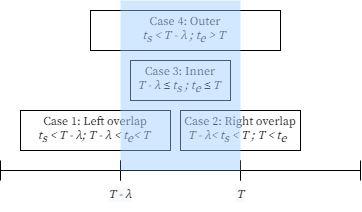

* Left overlap: $t_e$는 윈도우 내에 있으나, $t_s$는 윈도우 밖에 존재. 즉, 현재 윈도우 밖에 있는 $t_s$를 찾기 위해 전체 데이터를 탐색해야 함.
* Right overlap: $t_s$는 윈도우 내에 있으나, $t_e$는 윈도우 밖에 존재. 즉, 현재 윈도우 밖에 있는 $t_e$를 찾기 위해 전체 데이터를 탐색해야 함.
* Inner: $t_s$ 및 $t_e$가 윈도우 내에 존재.
* Outer: $t_s$ 및 $t_e$가 윈도우 밖에 존재. 즉, 현재 윈도우 밖에 있는 $t_s$ 및 $t_e$를 찾기 위해 전체 데이터를 탐색해야 함.

따라서, 정확한 특성값 계산을 하기 위해서는 4가지 경우를 모두 다루는 귀찮은 코드를 작성해야 한다.

대신에, 아주 조금 부정확하지만 간단하게 해결할 수 있는 방법이 있다. 레이블에 대한 전처리처럼 범주형 데이터 또한 Upsampling을 하는 것이다.


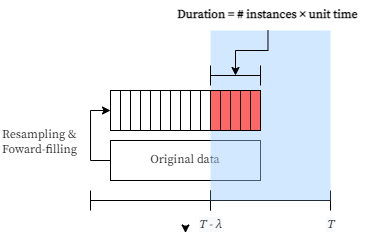

예를 들어, 아주 작은 시간 단위로 (예. 1초) 범주형 데이터를 Upsampling 및 Foward Filling 하게 되면, 각 윈도우 내의 샘플 개수는 같게 된다. 이 때, 윈도우 내의 특정한 상태가 지속된 시간은 Upsampling 한 시간 단위 X 특정 상태 값인 샘플의 개수와 같다. 이런 방법을 이용하면, 복잡하게 코드 작성을 할 필요 없이 샘플의 개수만 새어도 충분하다.

In [ ]:
SCREEN = DF_SCREEN.assign(
    timestamps=lambda x: pd.to_datetime(x['timestamps'], unit='ms')
).set_index(
    'timestamps'
)['status'].sort_index().resample(
    '500ms'
).ffill().dropna()

SCREEN

timestamps
2016-02-08 18:31:54.000    SCREEN_OFF
2016-02-08 18:31:54.500    SCREEN_OFF
2016-02-08 18:31:55.000    SCREEN_OFF
2016-02-08 18:31:55.500    SCREEN_OFF
2016-02-08 18:31:56.000    SCREEN_OFF
                              ...    
2016-02-08 20:34:53.500     SCREEN_ON
2016-02-08 20:34:54.000     SCREEN_ON
2016-02-08 20:34:54.500     SCREEN_ON
2016-02-08 20:34:55.000     SCREEN_ON
2016-02-08 20:34:55.500     SCREEN_ON
Freq: 500L, Name: status, Length: 14764, dtype: object

## Time-Domain Features

In [ ]:
import pandas as pd
import numpy as np
import scipy as sp


DATA_CAT = []

for t in LABEL.index:
    l = LABEL[t]
    sub = SCREEN.loc[t - pd.Timedelta(seconds=3):t - pd.Timedelta(milliseconds=1)]
    n = len(sub)
    prob_on = np.sum(sub == 'SCREEN_ON') / n if n != 0 else 0
    prob_off = np.sum(sub == 'SCREEN_OFF') / n if n != 0 else 0
    changes = np.sum(sub.values[1:] != sub.values[:-1])
    entropy = sp.stats.entropy([prob_on, prob_off]) if n != 0 else 0

    DATA_CAT.append(
        (t, l, prob_on, prob_off, changes, entropy)
    )

DATA_CAT = pd.DataFrame(DATA_CAT, columns=['timestamps', 'label', 'prof_on', 'prob_off', 'changes', 'entropy']).set_index(
    'timestamps'
)
DATA_CAT

,label,prof_on,prob_off,changes,entropy
timestamps,,,,,
2016-02-08 18:28:53,On Table,0.000000,0.000000,0,0.000000
2016-02-08 18:28:54,On Table,0.000000,0.000000,0,0.000000
2016-02-08 18:28:55,On Table,0.000000,0.000000,0,0.000000
2016-02-08 18:28:56,On Table,0.000000,0.000000,0,0.000000
2016-02-08 18:28:57,On Table,0.000000,0.000000,0,0.000000
...,...,...,...,...,...
2016-02-08 20:25:39,Walking,0.000000,1.000000,0,0.000000
2016-02-08 20:25:40,Walking,0.000000,1.000000,0,0.000000
2016-02-08 20:25:41,Walking,0.000000,1.000000,0,0.000000


In [ ]:
import altair as alt
import numpy as np


alt.data_transformers.disable_max_rows()
plots = alt.vconcat()

for feature in ['prof_on', 'prob_off', 'changes', 'entropy']:
    p = alt.Chart(DATA_CAT).encode(
        x='label', y=f'{feature}:Q'
    ).mark_boxplot().properties(width=400)
    plots = plots & p

plots

alt.VConcatChart(...)

그 외 수업시간에 소개된 Clustering 및 Feature Construction은 다른 시간에 실습해볼 것이다.

또한, 여기에 소개된 특성값은 어디까지나 일부일 뿐이다. 문제 분야 및 데이터 종류에 따라 엄청나게 많은 특성값을 추출할 수 있다. 따라서, 좋은 특성값 추출을 위해 중요한 것은 도메인 지식, 경험, 직관, 운, 그리고 반복적인 모델 훈련을 통한 성능 평가다.
